# Basic Heuristic Strategy: 2D Turbulence Snapshot

In [ ]:
using JLD2, Interpolations, Statistics

const n = 512 # grid resolution 
const L = 2π  # domain length           

##### Load Velocity Field #####
file = jldopen("../../../Data Generation/2d-turb-data.jld")
u_data = file["vel_x"][:,:,1]
v_data = file["vel_y"][:,:,1]
vort_data = file["vort"][:,:,1]
close(file)

##### Interpolations #####
itp_vort = interpolate(vort_data, BSpline(Linear(Periodic())))
itp_u = interpolate(u_data, BSpline(Linear(Periodic())))
itp_v = interpolate(v_data, BSpline(Linear(Periodic())))

etp_vort = extrapolate(itp_vort, Periodic())
etp_u = extrapolate(itp_u, Periodic())
etp_v = extrapolate(itp_v, Periodic())

vort(x,y) = etp_vort(n*x/L+1, n*y/L+1)
velX(x,y) = etp_u(n*x/L+1, n*y/L+1)
velY(x,y) = etp_v(n*x/L+1, n*y/L+1)

##### Start, End #####
xA = 1.2
yA = 5.5
rA = 0.2

xB = 5.2
yB = 1.8
rB = 0.2

N_tile = 30 
δ = L/N_tile # grid size for tiling

u0 = maximum(sqrt.(u_data.^2+v_data.^2)) # background maximum velocity
Va = 0.3*u0 # agent's velocity
Δt = δ/(2*u0) # agent's reaction time
Na = 8 # number of actions

n_episodes = 5000 # number of episodes for evaluation

T_free = sqrt((xB-xA)^2+(yB-yA)^2)/Va
T_max = 5*T_free

w_reward = 1.0 # weight in the reward function

# generate starting position
function start_point()
    ϕ = 2π*rand()
    r = rA*sqrt(rand())
    return xA+r*cos(ϕ), yA+r*sin(ϕ)
end

# checking that the agent did not hit the border or target
function is_terminal(x,y)
    if (x<=0)||(y<=0)||(x>=L)||(y>=L)
        return true
    elseif sqrt((xB-x)^2+(yB-y)^2)<=rB
        return true
    else
        return false
    end
end 

# choose control θ
function choose_TP_optimal_action(x,y)
    return atan(yB-y, xB-x)    
end

# choose control θ if the angent has only Na=8 options
function choose_TP_nearest_action(x,y)
    θ_star = atan(yB-y, xB-x)    
    if -π/8 < θ_star <= π/8
        return 0
    elseif π/8 < θ_star <= 3π/8
        return π/4
    elseif 3π/8 < θ_star <= 5π/8
        return π/2
    elseif 5π/8 < θ_star <= 7π/8
        return 3π/4
    elseif -3π/8 < θ_star <= -π/8
        return -π/4
    elseif -5π/8 < θ_star <= -3π/8
        return -π/2
    elseif -7π/8 < θ_star <= -5π/8
        return -3π/4
    else
        return π
    end      
end

nothing

In [2]:
# here we integrate the equations of motion over an interval Δt
using OrdinaryDiffEq

function advection!(du, u, p, t)
    x, y = u
    θ = p
    du[1] = dx = velX(x,y) + Va*cos(θ)
    du[2] = dy = velY(x,y) + Va*sin(θ)
end

tspan = (0.0, Δt)

function next_state(x, y, θ)
    prob = ODEProblem(advection!, [x, y], tspan, θ)
    sol = solve(prob, Tsit5(), p = θ, reltol = 1e-12, abstol = 1e-12)
    return sol(Δt)[1], sol(Δt)[2]
end

nothing

In [3]:
# here we evaluate n_episodes runs
# we save trajectories and total rewards
# the values of rewards are used for comparison with RL algorithms
x_tracks_TP = []
y_tracks_TP = []
θ_tracks_TP = []
r_tracks_TP = []

# indicator that shows whether the end point has been reached
success_TP = ones(n_episodes)

for i in 1:n_episodes
    # trajectory and rewards for current episode
    x_points_TP = []
    y_points_TP = []
    θ_points_TP = []
    r_points_TP = []

    # generating random starting position
    x_now, y_now = start_point()
    step = 0

    while (is_terminal(x_now, y_now)==false)&&(step*Δt<T_max)        
        # choose action θ
        θ_now = choose_TP_nearest_action(x_now, y_now)
        
        # add current point to arrays
        push!(x_points_TP, x_now)
        push!(y_points_TP, y_now)
        push!(θ_points_TP, θ_now)
        
        # calculate next position
        x_next, y_next = next_state(x_now, y_now, θ_now)
        step+=1
        
        # calculate reward
        reward = -Δt + w_reward*(sqrt((xB-x_now)^2+(yB-y_now)^2)/Va - sqrt((xB-x_next)^2+(yB-y_next)^2)/Va)
        
        # checking that the agent did not hit the border and did not run out of time
        if (x_next<=0)||(y_next<=0)||(x_next>=L)||(y_next>=L)
            reward=reward-2*T_max
            success_TP[i]=0
        elseif step*Δt>=T_max
            success_TP[i]=0
        end
        
        # save reward
        push!(r_points_TP, reward)
        
        # update current position
        x_now, y_now = x_next, y_next 
    end
    
    # end of episode
    if is_terminal(x_now, y_now)==true
        push!(x_points_TP, x_now)
        push!(y_points_TP, y_now)
    end
    
    # save trajectory and total reward for finished episode 
    push!(x_tracks_TP, x_points_TP)
    push!(y_tracks_TP, y_points_TP)
    push!(θ_tracks_TP, θ_points_TP)
    push!(r_tracks_TP, sum(r_points_TP))
    
end

# Visualization

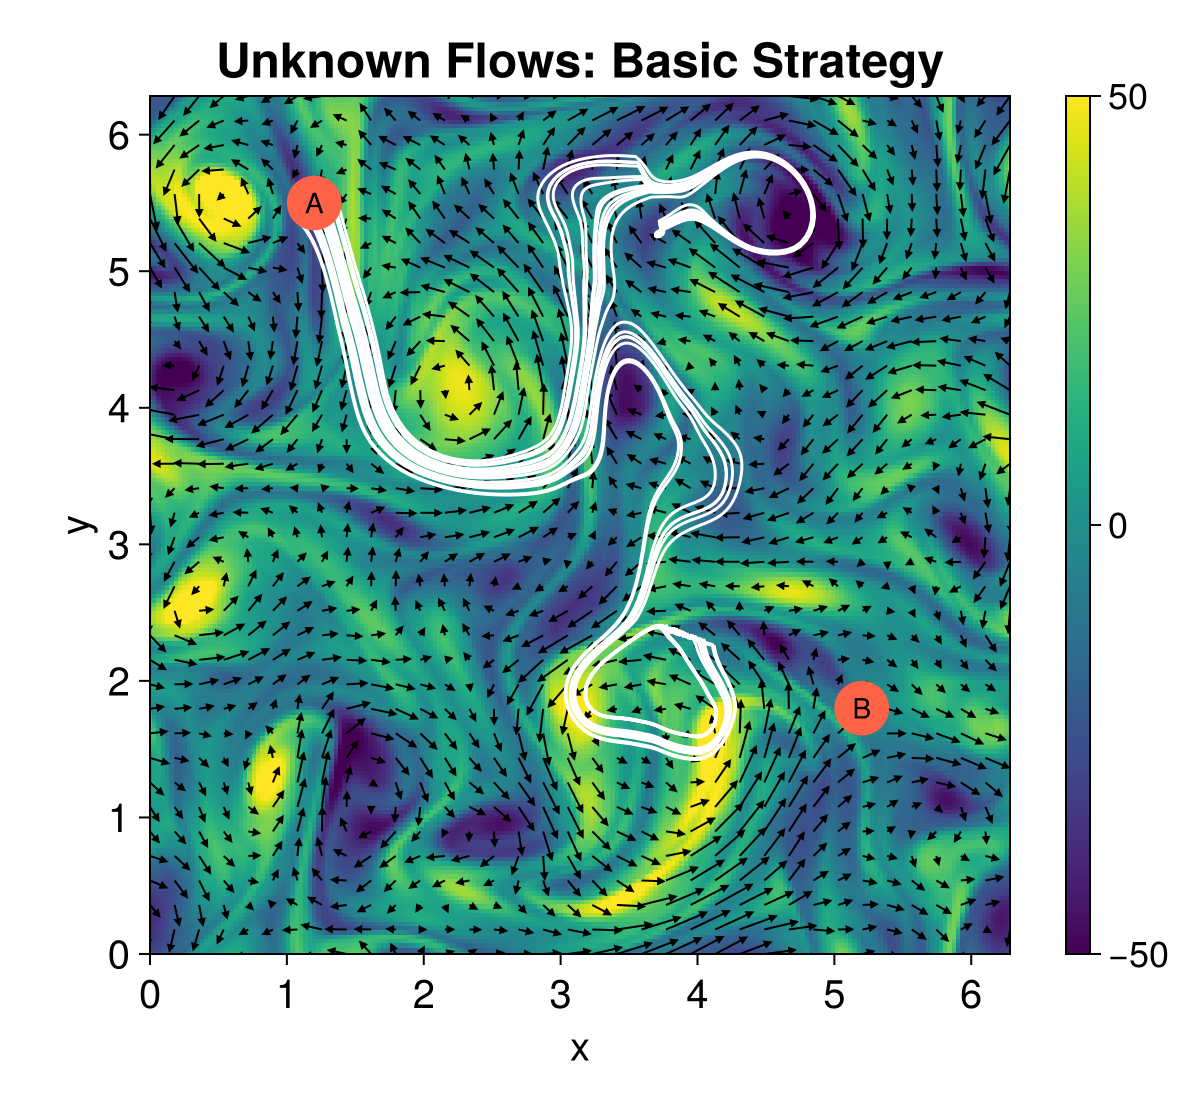

In [4]:
using CairoMakie

xs = range(0, L, length=200)
ys = range(0, L, length=200)
zs = [vort(x,y) for x in xs, y in ys]

xs2 = LinRange(0, L, 36)
ys2 = LinRange(0, L, 36)
us2 = [velX(x,y) for x in xs2, y in ys2]
vs2 = [velY(x,y) for x in xs2, y in ys2]

fig = Figure(size = (600, 550))

ax = Axis(fig[1, 1],
    title = "Unknown Flows: Basic Strategy", titlesize=24,
    xlabel = "x", xlabelsize=20, xticklabelsize=20,
    ylabel = "y", ylabelsize=20, yticklabelsize=20,
    aspect = 1, limits = ((0, L), (0,L))
)

hm = heatmap!(ax, xs, ys, zs, colormap = :viridis, alpha=1.0, colorrange=(-50, 50))
Colorbar(fig[:, end+1], hm, ticklabelsize=18)

#hlines!(ax, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)
#vlines!(ax, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)

arrows!(ax, xs2, ys2, us2, vs2, arrowsize = 6, lengthscale = 0.02,)

# show several episodes
for i in 1:20
    lines!(ax, x_tracks_TP[i], y_tracks_TP[i], color=:white)
end

poly!(ax, Circle(Point2f(xA, yA), rA), color = :tomato)
text!(xA, yA, text = "A", align = (:center, :center))

poly!(ax, Circle(Point2f(xB, yB), rB), color = :tomato)
text!(xB, yB, text = "B", align = (:center, :center))

save("2d-turb-snapshot + tracks.pdf", fig)
fig

### Statistics of Success Times

In [5]:
times_TP = zeros(Int(sum(success_TP))) # how long does it take to reach the target?
count_TP = 0

# calculate time when the agent reaches the end point
for i in 1:n_episodes
    if success_TP[i]==1
        count_TP+=1
        times_TP[count_TP] = length(x_tracks_TP[i])*Δt
    end
end

# estimate fail probability and average reward
println("Fail Probabitity = ", 1-sum(success_TP)/n_episodes)
println("Average Reward = ", sum(r_tracks_TP)/n_episodes)

#=
fig = Figure(size = (600, 600))

ax = Axis(fig[1, 1],
    title = "Unknown Flows: Basic Strategy", titlesize=24,
    xlabel = "Success Time", xlabelsize=20, xticklabelsize=20,
    ylabel = "PDF", ylabelsize=20, yticklabelsize=20,
    aspect = 1, limits = ((0, 2.0), (0,30))
)

hist!(ax, times_TP, normalization = :pdf, bins=0:0.025:4, strokewidth = 1, strokecolor = :black)

fig
=#

Fail Probabitity = 1.0
Average Reward = -5.472254674302705
